In [1]:
import warnings
warnings.filterwarnings("ignore")
import pickle
import numpy as np
import joblib
import tensorflow as tf
from tensorflow import keras
#from keras.models import load_model
from PIL import Image #python imaging library
from tensorflow.python.ops.rnn_cell_impl import LSTMCell, ResidualWrapper, DropoutWrapper, MultiRNNCell
import os
import sys
import cv2
import math
import csv
import glob
import unidecode
import simplejson
import matplotlib.pyplot as plt

In [2]:
class Model():
    def __init__(self, loc, operation='activation', input_name='x'):
        self.input = input_name + ":0"
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph)
        with self.graph.as_default():
            saver = tf.train.import_meta_graph(loc + '.meta', clear_devices=True)
            saver.restore(self.sess, loc)
            self.op = self.graph.get_operation_by_name(operation).outputs[0]

    def run(self, data):
        """Run the specified operation on given data."""
        return self.sess.run(self.op, feed_dict={self.input: data})
    
    def eval_feed(self, feed):
        """Run the specified operation with given feed."""
        return self.sess.run(self.op, feed_dict=feed)
    
    def run_op(self, op, feed, output=True):
        """Run given operation with the feed."""
        if output:
            return self.sess.run(
                self.graph.get_operation_by_name(op).outputs[0],
                feed_dict=feed)
        else:
            self.sess.run(
                self.graph.get_operation_by_name(op),
                feed_dict=feed)

In [3]:
def detection(image, area_thresh = 0.5):
    """Finding Page."""
    small = resize(image)
    # Edge detection
    image_edges = _edges_detection(small, 200, 250)
    
    # Close gaps between edges (double page clouse => rectangle kernel)
    closed_edges = cv2.morphologyEx(image_edges, 
                                    cv2.MORPH_CLOSE, 
                                    np.ones((5, 11)))
    # Countours
    page_contour = _find_page_contours(closed_edges, small, area_thresh)

    # Recalculate to original scale
    page_contour = page_contour.dot(ratio(image, small.shape[0]))
    # Transform prespective
    new_image = _persp_transform(image, page_contour)
    return new_image
   

def _edges_detection(img, minVal, maxVal):
    """Preprocessing (gray, thresh, filter, border) + Canny edge detection."""
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.adaptiveThreshold(img, 255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 115, 4)

    # Median blur replace center pixel by median of pixels under kelner
    # => removes thin details
    img = cv2.medianBlur(img, 11)

    # Add black border - detection of border touching pages
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5,
                             cv2.BORDER_CONSTANT,
                             value=[0, 0, 0])
    return cv2.Canny(img, minVal, maxVal)


def _four_corners_sort(pts):
    """Sort corners in order: top-left, bot-left, bot-right, top-right."""
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])


def _contour_offset(cnt, offset):
    """Offset contour because of border."""
    cnt += offset
    cnt[cnt < 0] = 0
    return cnt


def _find_page_contours(edges, img, area_thresh):
    """Finding corner points of page contour."""
    contours, hierarchy = cv2.findContours(edges,
                                                cv2.RETR_TREE,
                                                cv2.CHAIN_APPROX_SIMPLE)
    
    # Finding biggest rectangle otherwise return original corners
    height = edges.shape[0]
    width = edges.shape[1]
    MIN_COUNTOUR_AREA = height * width * area_thresh
    MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

    max_area = MIN_COUNTOUR_AREA
    page_contour = np.array([[0, 0],
                             [0, height-5],
                             [width-5, height-5],
                             [width-5, 0]])

    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

        # Page has 4 corners and it is convex
        if (len(approx) == 4 and
                cv2.isContourConvex(approx) and
                max_area < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):
            
            max_area = cv2.contourArea(approx)
            page_contour = approx[:, 0]

    # Sort corners and offset them
    page_contour = _four_corners_sort(page_contour)
    return _contour_offset(page_contour, (-5, -5))


def _persp_transform(img, s_points):
    """Transform perspective from start points to target points."""
    # Euclidean distance - calculate maximum height and width
    height = max(np.linalg.norm(s_points[0] - s_points[1]),
                 np.linalg.norm(s_points[2] - s_points[3]))
    width = max(np.linalg.norm(s_points[1] - s_points[2]),
                 np.linalg.norm(s_points[3] - s_points[0]))
    
    # Create target points
    t_points = np.array([[0, 0],
                        [0, height],
                        [width, height],
                        [width, 0]], np.float32)
    
    # getPerspectiveTransform() needs float32
    if s_points.dtype != np.float32:
        s_points = s_points.astype(np.float32)
    
    M = cv2.getPerspectiveTransform(s_points, t_points) 
    return cv2.warpPerspective(img, M, (int(width), int(height)))

In [4]:

def detections(image, join=False):
    """Detecting the words bounding boxes.
    Return: numpy array of bounding boxes [x, y, x+w, y+h]
    """
    # Preprocess image for word detection
    blurred = cv2.GaussianBlur(image, (5, 5), 18)
    edge_img = _edge_detect(blurred)
    ret, edge_img = cv2.threshold(edge_img, 50, 255, cv2.THRESH_BINARY)
    bw_img = cv2.morphologyEx(edge_img, cv2.MORPH_CLOSE,
                              np.ones((15,15), np.uint8))

    return _text_detect(bw_img, image, join)


def sort_words(boxes):
    """Sort boxes - (x, y, x+w, y+h) from left to right, top to bottom."""
    mean_height = sum([y2 - y1 for _, y1, _, y2 in boxes]) / len(boxes)
    
    boxes.view('i8,i8,i8,i8').sort(order=['f1'], axis=0)
    current_line = boxes[0][1]
    lines = []
    tmp_line = []
    for box in boxes:
        if box[1] > current_line + mean_height:
            lines.append(tmp_line)
            tmp_line = [box]
            current_line = box[1]            
            continue
        tmp_line.append(box)
    lines.append(tmp_line)
        
    for line in lines:
        line.sort(key=lambda box: box[0])
        
    return lines


def _edge_detect(im):
    """ 
    Edge detection using sobel operator on each layer individually.
    Sobel operator is applied for each image layer (RGB)
    """
    return np.max(np.array([_sobel_detect(im[:,:, 0]),
                            _sobel_detect(im[:,:, 1]),
                            _sobel_detect(im[:,:, 2])]), axis=0)


def _sobel_detect(channel):
    """Sobel operator."""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return np.uint8(sobel)


def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return [x, y, w, h]

def _intersect(a,b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0]+a[2], b[0]+b[2]) - x
    h = min(a[1]+a[3], b[1]+b[3]) - y
    if w<0 or h<0:
        return False
    return True

def _group_rectangles(rec):
    """
    Uion intersecting rectangles.
    Args:
        rec - list of rectangles in form [x, y, w, h]
    Return:
        list of grouped ractangles 
    """
    tested = [False for i in range(len(rec))]
    final = []
    i = 0
    while i < len(rec):
        if not tested[i]:
            j = i+1
            while j < len(rec):
                if not tested[j] and _intersect(rec[i], rec[j]):
                    rec[i] = union(rec[i], rec[j])
                    tested[j] = True
                    j = i
                j += 1
            final += [rec[i]]
        i += 1
            
    return final


def _text_detect(img, image, join=False):
    """Text detection using contours."""
    small = resize(img, 2000)
    
    # Finding contours
    mask = np.zeros(small.shape, np.uint8)
    cnt, hierarchy = cv2.findContours(np.copy(small),
                                           cv2.RETR_CCOMP,
                                           cv2.CHAIN_APPROX_SIMPLE)
    
    index = 0    
    boxes = []
    # Go through all contours in top level
    while (index >= 0):
        x,y,w,h = cv2.boundingRect(cnt[index])
        cv2.drawContours(mask, cnt, index, (255, 255, 255), cv2.FILLED)
        maskROI = mask[y:y+h, x:x+w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text
        if (r > 0.1
            and 1600 > w > 10
            and 1600 > h > 10
            and h/w < 3
            and w/h < 10
            and (60 // h) * w < 1000):
            boxes += [[x, y, w, h]]
            
        index = hierarchy[0][index][0]

    if join:
        # Need more work
        boxes = _group_rectangles(boxes)

    # image for drawing bounding boxes
    small = cv2.cvtColor(small, cv2.COLOR_GRAY2RGB)
    bounding_boxes = np.array([0,0,0,0])
    for (x, y, w, h) in boxes:
        cv2.rectangle(small, (x, y),(x+w,y+h), (0, 255, 0), 2)
        bounding_boxes = np.vstack((bounding_boxes,
                                    np.array([x, y, x+w, y+h])))
        
    implt(small, t='Bounding rectangles')
    
    boxes = bounding_boxes.dot(ratio(image, small.shape[0])).astype(np.int64)
    return boxes[1:]  
    

def textDetectWatershed(thresh):
    """NOT IN USE - Text detection using watershed algorithm.
    Based on: http://docs.opencv.org/trunk/d3/db4/tutorial_py_watershed.html
    """
    img = cv2.cvtColor(cv2.imread("data/textdet/%s.jpg" % img),
                       cv2.COLOR_BGR2RGB)
    img = resize(img, 3000)
    thresh = resize(thresh, 3000)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)
    
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,
                                 0.01*dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers += 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0
    
    markers = cv2.watershed(img, markers)
    implt(markers, t='Markers')
    image = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    for mark in np.unique(markers):
        # mark == 0 --> background
        if mark == 0:
            continue

        # Draw it on mask and detect biggest contour
        mask = np.zeros(gray.shape, dtype="uint8")
        mask[markers == mark] = 255

        cnts = cv2.findContours(mask.copy(),
                                cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)[-2]
        c = max(cnts, key=cv2.contourArea)
        
        # Draw a bounding rectangle if it contains text
        x,y,w,h = cv2.boundingRect(c)
        cv2.drawContours(mask, c, 0, (255, 255, 255), cv2.FILLED)
        maskROI = mask[y:y+h, x:x+w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text
        if r > 0.2 and 2000 > w > 15 and 1500 > h > 15:
            cv2.rectangle(image, (x, y),(x+w,y+h), (0, 255, 0), 2)
        
    implt(image)

In [5]:
print("Loading segmentation models...")
location = os.path.dirname(os.path.abspath('F:/MY_PROJECT/models/gap-clas/'))
CNN_model = Model(
    os.path.join(location, 'F:/MY_PROJECT/models/gap-clas/CNN-CG'))
CNN_slider = (60, 30)
RNN_model = Model(
    os.path.join(location, 'F:/MY_PROJECT/models/gap-clas/RNN/Bi-RNN-new'),
    'prediction')
RNN_slider = (60, 60)


def _classify(img, step=2, RNN=False, slider=(60, 60)):
    """Slice the image and return raw output of classifier."""
    length = (img.shape[1] - slider[1]) // 2 + 1
    if RNN:
        input_seq = np.zeros((1, length, slider[0]*slider[1]), dtype=np.float32)
        input_seq[0][:] = [img[:, loc * step: loc * step + slider[1]].flatten()
                           for loc in range(length)]
        pred = RNN_model.eval_feed({'inputs:0': input_seq,
                                    'length:0': [length],
                                    'keep_prob:0': 1})[0]
    else:
        input_seq = np.zeros((length, slider[0]*slider[1]), dtype=np.float32)
        input_seq[:] = [img[:, loc * step: loc * step + slider[1]].flatten()
                        for loc in range(length)]
        pred = CNN_model.run(input_seq)
        
    return pred  

def segment(img, step=2, RNN=False, debug=False):
    """Take preprocessed image of word and
    returns array of positions separating characters.
    """
    slider = CNN_slider
    if RNN:
        slider = RNN_slider
    
    # Run the classifier
    pred = _classify(img, step=step, RNN=RNN, slider=slider)

    # Finalize the gap positions from raw prediction
    gaps = []
    last_gap = 0
    gap_count = 1
    gap_position_sum = slider[1] / 2
    first_gap = True
    gap_block_first = 0
    gap_block_last = slider[1] / 2

    for i, p in enumerate(pred):
        if p == 1:
            gap_position_sum += i * step + slider[1] / 2
            gap_block_last = i * step + slider[1] / 2
            gap_count += 1
            last_gap = 0
            if gap_block_first == 0:
                gap_block_first = i * step + slider[1] / 2
        else:
            if gap_count != 0 and last_gap >= 1:
                if first_gap:
                    gaps.append(int(gap_block_last))
                    first_gap = False
                else:
                    gaps.append(int(gap_position_sum // gap_count))
                gap_position_sum = 0
                gap_count = 0
            gap_block_first = 0
            last_gap += 1

    # Adding final gap position
    if gap_block_first != 0:
        gaps.append(int(gap_block_first))
    else:
        gap_position_sum += (len(pred) - 1) * 2 + slider[1]/2
        gaps.append(int(gap_position_sum / (gap_count + 1)))
        
    if debug:
        # Drawing lines
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        for gap in gaps:
            cv2.line(img,
                     ((int)(gap), 0),
                     ((int)(gap), slider[0]),
                     (0, 255, 0), 1)
        implt(img, t="Separated characters")
        
    return gaps

Loading segmentation models...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from F:/MY_PROJECT/models/gap-clas/CNN-CG
INFO:tensorflow:Restoring parameters from F:/MY_PROJECT/models/gap-clas/RNN/Bi-RNN-new


In [6]:

SMALL_HEIGHT = 800


def implt(img, cmp=None, t=''):
    """Show image using plt."""
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()


def resize(img, height=SMALL_HEIGHT, always=False):
    """Resize image to given height."""
    if (img.shape[0] > height or always):
        rat = height / img.shape[0]
        return cv2.resize(img, (int(rat * img.shape[1]), height))
    
    return img


def ratio(img, height=SMALL_HEIGHT):
    """Getting scale ratio."""
    return img.shape[0] / height


def img_extend(img, shape):
    """Extend 2D image (numpy array) in vertical and horizontal direction.
    Shape of result image will match 'shape'
    Args:
        img: image to be extended
        shape: shape (touple) of result image
    Returns:
        Extended image
    """
    x = np.zeros(shape, np.uint8)
    x[:img.shape[0], :img.shape[1]] = img
    return x

In [7]:

def image_standardization(image):
    """Image standardization should result in same output 
    as tf.image.per_image_standardization.
    """
    return (image - np.mean(image)) / max(np.std(image), 1.0/math.sqrt(image.size))


def _crop_add_border(img, height, threshold=50, border=True, border_size=15):
    """Crop and add border to word image of letter segmentation."""
    # Clear small values

    ret, img = cv2.threshold(img, threshold, 255, cv2.THRESH_TOZERO)

    x0 = 0
    y0 = 0
    x1 = img.shape[1]
    y1 = img.shape[0]

    for i in range(img.shape[0]):
        if np.count_nonzero(img[i, :]) > 1:
            y0 = i
            break
    for i in reversed(range(img.shape[0])):
        if np.count_nonzero(img[i, :]) > 1:
            y1 = i+1
            break
    for i in range(img.shape[1]):
        if np.count_nonzero(img[:, i]) > 1:
            x0 = i
            break
    for i in reversed(range(img.shape[1])):
        if np.count_nonzero(img[:, i]) > 1:
            x1 = i+1
            break

    if height != 0:
        img = resize(img[y0:y1, x0:x1], height, True)
    else:
        img = img[y0:y1, x0:x1]

    if border:
        return cv2.copyMakeBorder(img, 0, 0, border_size, border_size,
                                  cv2.BORDER_CONSTANT,
                                  value=[0, 0, 0])
    return img


def _word_tilt(img, height, border=True, border_size=15):
    """Detect the angle and tilt the image."""
    edges = cv2.Canny(img, 50, 150, apertureSize = 3)
    lines = cv2.HoughLines(edges, 1, np.pi/180, 30)

    if lines is not None:
        meanAngle = 0
        # Set min number of valid lines (try higher)
        numLines = np.sum(1 for l in lines if l[0][1] < 0.7 or l[0][1] > 2.6)
        if numLines > 1:
            meanAngle = np.mean([l[0][1] for l in lines if l[0][1] < 0.7 or l[0][1] > 2.6])

        # Look for angle with correct value
        if meanAngle != 0 and (meanAngle < 0.7 or meanAngle > 2.6):
            img = _tilt_by_angle(img, meanAngle, height)
    return _crop_add_border(img, height, 50, border, border_size)


def _tilt_by_angle(img, angle, height):
    """Tilt the image by given angle."""
    dist = np.tan(angle) * height
    width = len(img[0])
    sPoints = np.float32([[0,0], [0,height], [width,height], [width,0]])

    # Dist is positive for angle < 0.7; negative for angle > 2.6
    # Image must be shifed to right
    if dist > 0:
        tPoints = np.float32([[0,0],
                              [dist,height],
                              [width+dist,height],
                              [width,0]])
    else:
        tPoints = np.float32([[-dist,0],
                              [0,height],
                              [width,height],
                              [width-dist,0]])

    M = cv2.getPerspectiveTransform(sPoints, tPoints)
    return cv2.warpPerspective(img, M, (int(width+abs(dist)), height))


def _sobel_detect(channel):
    """The Sobel Operator."""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    # Combine x, y gradient magnitudes sqrt(x^2 + y^2)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return np.uint8(sobel)


class HysterThresh:
    def __init__(self, img):
        img = 255 - img
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
        hist, bins = np.histogram(img.ravel(), 256, [0,256])

        self.high = np.argmax(hist) + 65
        self.low = np.argmax(hist) + 45
        self.diff = 255 - self.high

        self.img = img
        self.im = np.zeros(img.shape, dtype=img.dtype)

    def get_image(self):
        self._hyster()
        return np.uint8(self.im)

    def _hyster_rec(self, r, c):
        h, w = self.img.shape
        for ri in range(r-1, r+2):
            for ci in range(c-1, c+2):
                if (h > ri >= 0
                    and w > ci >= 0
                    and self.im[ri, ci] == 0
                    and self.high > self.img[ri, ci] >= self.low):
                    self.im[ri, ci] = self.img[ri, ci] + self.diff
                    self._hyster_rec(ri, ci)

    def _hyster(self):
        r, c = self.img.shape
        for ri in range(r):
            for ci in range(c):
                if (self.img[ri, ci] >= self.high):
                    self.im[ri, ci] = 255
                    self.img[ri, ci] = 255
                    self._hyster_rec(ri, ci)


def _hyst_word_norm(image):
    """Word normalization using hystheresis thresholding."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     img = cv2.bilateralFilter(gray, 0, 10, 30)
    img = cv2.bilateralFilter(gray, 10, 10, 30)
    return HysterThresh(img).get_image()


def word_normalization(image, height, border=True, tilt=True, border_size=15, hyst_norm=False):
    """ Preprocess a word - resize, binarize, tilt world."""
    image = resize(image, height, True)

    if hyst_norm:
        th = _hyst_word_norm(image)
    else:
        img = cv2.bilateralFilter(image, 10, 30, 30)
        gray = 255 - cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        norm = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
        ret,th = cv2.threshold(norm, 50, 255, cv2.THRESH_TOZERO)

    if tilt:
        return _word_tilt(th, height, border, border_size)
    return _crop_add_border(th, height=height, border=border, border_size=border_size)


def _resize_letter(img, size = 56):
    """Resize bigger side of the image to given size."""
    if (img.shape[0] > img.shape[1]):
        rat = size / img.shape[0]
        return cv2.resize(img, (int(rat * img.shape[1]), size))
    else:
        rat = size / img.shape[1]
        return cv2.resize(img, (size, int(rat * img.shape[0])))
    return img


def letter_normalization(image, is_thresh=True, dim=False):
    """Preprocess a letter - crop, resize"""
    if is_thresh and image.shape[0] > 0 and image.shape[1] > 0:
        image = _crop_add_border(image, height=0, threshold=80, border=False)

    resized = image
    if image.shape[0] > 1 and image.shape[1] > 1:
        resized = _resize_letter(image)

    result = np.zeros((64, 64), np.uint8)
    offset = [0, 0]
    # Calculate offset for smaller size
    if image.shape[0] > image.shape[1]:
        offset = [int((result.shape[1] - resized.shape[1])/2), 4]
    else:
        offset = [4, int((result.shape[0] - resized.shape[0])/2)]
    # Replace zeros by image 
    result[offset[1]:offset[1] + resized.shape[0],
           offset[0]:offset[0] + resized.shape[1]] = resized

    if dim:
        return result, image.shape
    return result



In [8]:

CHARS = ['', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
         'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
         'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
         'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
         'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
         'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6',
         '7', '8', '9', '.', '-', '+', "'"]
CHAR_SIZE = len(CHARS)
idxs = [i for i in range(len(CHARS))]
idx_2_chars = dict(zip(idxs, CHARS))
chars_2_idx = dict(zip(CHARS, idxs))

def char2idx(c, sequence=False):
    if sequence:
        return chars_2_idx[c] + 1
    return chars_2_idx[c]

def idx2char(idx, sequence=False):
    if sequence:
        return idx_2_chars[idx-1]
    return idx_2_chars[idx]
    

def load_words_data(dataloc='data/words/', is_csv=False, load_gaplines=False):
    
    print("Loading words...")
    if type(dataloc) is not list:
        dataloc = [dataloc]

    if is_csv:
        csv.field_size_limit(sys.maxsize)
        length = 0
        for loc in dataloc:
            with open(loc) as csvfile:
                reader = csv.reader(csvfile)
                length += max(sum(1 for row in csvfile)-1, 0)

        labels = np.empty(length, dtype=object)
        images = np.empty(length, dtype=object)
        i = 0
        for loc in dataloc:
            print(loc)
            with open(loc) as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    shape = np.fromstring(
                        row['shape'],
                        sep=',',
                        dtype=int)
                    img = np.fromstring(
                        row['image'],
                        sep=', ',
                        dtype=np.uint8).reshape(shape)
                    labels[i] = row['label']
                    images[i] = img
                    
                    print_progress_bar(i, length)
                    i += 1
    else:
        img_list = []
        tmp_labels = []
        for loc in dataloc:
            tmp_list = glob.glob(os.path.join(loc, '*.png'))
            img_list += tmp_list
            tmp_labels += [name[len(loc):].split("_")[0] for name in tmp_list]

        labels = np.array(tmp_labels)
        images = np.empty(len(img_list), dtype=object)

        # Load grayscaled images
        for i, img in enumerate(img_list):
            images[i] = cv2.imread(img, 0)
            print_progress_bar(i, len(img_list))

        # Load gaplines (lines separating letters) from txt files
        if load_gaplines:
            gaplines = np.empty(len(img_list), dtype=object)
            for i, name in enumerate(img_list):
                with open(name[:-3] + 'txt', 'r') as fp:
                    gaplines[i] = np.array(simplejson.load(fp))
                
    if load_gaplines:
        assert len(labels) == len(images) == len(gaplines)
    else:
        assert len(labels) == len(images)
    print("-> Number of words:", len(labels))
    
    if load_gaplines:
        return (images, labels, gaplines)
    return (images, labels)


def _words2chars(images, labels, gaplines):
    """Transform word images with gaplines into individual chars."""
    # Total number of chars
    length = sum([len(l) for l in labels])
    
    imgs = np.empty(length, dtype=object)
    new_labels = []
    
    height = images[0].shape[0]
    
    idx = 0;
    for i, gaps in enumerate(gaplines):
        for pos in range(len(gaps) - 1):
            imgs[idx] = images[i][0:height, gaps[pos]:gaps[pos+1]]
            new_labels.append(char2idx(labels[i][pos]))
            idx += 1
           
    print("Loaded chars from words:", length)            
    return imgs, new_labels


def load_chars_data(charloc='data/charclas/', wordloc='data/words/', lang='cz'):
   
    print("Loading chars...")
    images = np.zeros((1, 4096))
    labels = []

    if charloc != '':
        # Get subfolders with chars
        dir_list = glob.glob(os.path.join(charloc, lang, "*/"))
        dir_list.sort()    

        # if lang == 'en':
        chars = CHARS[:53]
            
        assert [d[-2] if d[-2] != '0' else '' for d in dir_list] == chars

        # For every label load images and create corresponding labels
        # cv2.imread(img, 0) - for loading images in grayscale
        # Images are scaled to 64x64 = 4096 px
        for i in range(len(chars)):
            img_list = glob.glob(os.path.join(dir_list[i], '*.jpg'))
            imgs = np.array([letter_normalization(cv2.imread(img, 0)) for img in img_list])
            images = np.concatenate([images, imgs.reshape(len(imgs), 4096)])
            labels.extend([i] * len(imgs))
        
    if wordloc != '':    
        imgs, words, gaplines = load_words_data(wordloc, load_gaplines=True)
        if lang != 'cz':
             words = np.array([unidecode.unidecode(w) for w in words])
        imgs, chars = _words2chars(imgs, words, gaplines)
        
        labels.extend(chars)
        images2 = np.zeros((len(imgs), 4096)) 
        for i in range(len(imgs)):
            print_progress_bar(i, len(imgs))
            images2[i] = letter_normalization(imgs[i]).reshape(1, 4096)

        images = np.concatenate([images, images2])          

    images = images[1:]
    labels = np.array(labels)
    
    print("-> Number of chars:", len(labels))
    return (images, labels)


def load_gap_data(loc='data/gapdet/large/', slider=(60, 120), seq=False, flatten=True):
    
    print('Loading gap data...')
    dir_list = glob.glob(os.path.join(loc, "*/"))
    dir_list.sort()
    
    if slider[1] > 120:
        # TODO Implement for higher dimmensions
        slider[1] = 120
        
    cut_s = None if (120 - slider[1]) // 2 <= 0 else  (120 - slider[1]) // 2
    cut_e = None if (120 - slider[1]) // 2 <= 0 else -(120 - slider[1]) // 2
    
    if seq:
        images = np.empty(len(dir_list), dtype=object)
        labels = np.empty(len(dir_list), dtype=object)
        
        for i, loc in enumerate(dir_list):
            # TODO Check for empty directories
            img_list = glob.glob(os.path.join(loc, '*.jpg'))
            if (len(img_list) != 0):
                img_list = sorted(img_list, key=lambda x: int(x[len(loc):].split("_")[1][:-4]))
                images[i] = np.array([(cv2.imread(img, 0)[:, cut_s:cut_e].flatten() if flatten else
                                       cv2.imread(img, 0)[:, cut_s:cut_e])
                                      for img in img_list])
                labels[i] = np.array([int(name[len(loc):].split("_")[0]) for name in img_list])
        
    else:
        images = np.zeros((1, slider[0]*slider[1]))
        labels = []

        for i in range(len(dir_list)):
            img_list = glob.glob(os.path.join(dir_list[i], '*.jpg'))
            if (len(img_list) != 0):
                imgs = np.array([cv2.imread(img, 0)[:, cut_s:cut_e] for img in img_list])
                images = np.concatenate([images, imgs.reshape(len(imgs), slider[0]*slider[1])])
                labels.extend([int(img[len(dir_list[i])]) for img in img_list])

        images = images[1:]
        labels = np.array(labels)
    
    if seq:
        print("-> Number of words / gaps and letters:",
              len(labels), '/', sum([len(l) for l in labels]))
    else:
        print("-> Number of gaps and letters:", len(labels))
    return (images, labels)    


def corresponding_shuffle(a):
    
    assert all([len(a[0]) == len(a[i]) for i in range(len(a))])
    p = np.random.permutation(len(a[0]))
    for i in range(len(a)):
        a[i] = a[i][p]
    return a


def sequences_to_sparse(sequences):
    
    indices = []
    values = []

    for n, seq in enumerate(sequences):
        indices.extend(zip([n]*len(seq), range(len(seq))))
        values.extend(seq)
        
    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=np.int32)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1]+1], dtype=np.int64)

    return indices, values, shape


In [9]:

def print_progress_bar(iteration,
                       total,
                       prefix = '',
                       suffix = ''):
   
    # Printing slowes down the loop
    if iteration % (total // 100) == 0:
        length = 40
        iteration += 1
        percent = (100 * iteration) // (total * 99/100)
        filled_length = int(length * percent / 100)
        bar = '█' * filled_length + '-' * (length - filled_length)
        print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')

        if iteration >= total * 99/100:
            print()


In [10]:
def recognise(img):
    """Recognising words using CTC Model."""
    
    img = word_normalization(img,64,border=False,tilt=False,hyst_norm=False)
    length = img.shape[1]
    # Input has shape [batch_size, height, width, 1]
    input_imgs = np.zeros(
            (1, 64, length, 1), dtype=np.uint8)
    input_imgs[0][:, :length, 0] = img

    pred = model.eval_feed({
        'inputs:0': input_imgs,
        'inputs_length:0': [length],
        'keep_prob:0': 1})[0]

    word = ''
    for i in pred:
        word += idx2char(i + 1)
    return word


In [11]:
MODEL_LOC_CTC = 'F:/MY_PROJECT/models/word-clas/CTC/Classifier1'
model = Model(MODEL_LOC_CTC, 'word_prediction')

INFO:tensorflow:Restoring parameters from F:/MY_PROJECT/models/word-clas/CTC/Classifier1


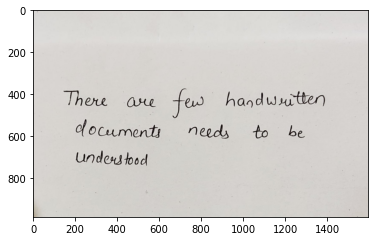

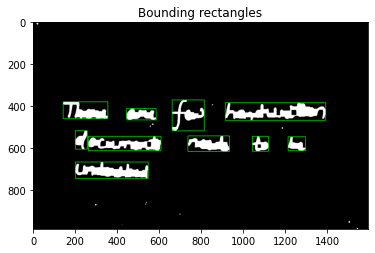

There arre few handwsitten
of ocurments neey to be
understood


In [12]:
IMG = 'F:/project/new data/WhatsApp Image 2023-03-06 at 23.03.20.jpg' 
image = cv2.cvtColor(cv2.imread(IMG), cv2.COLOR_BGR2RGB)
crop = detection(image)
implt(crop)
boxes = detections(crop)
lines = sort_words(boxes)

for line in lines:
    print(" ".join([recognise(crop[y1:y2, x1:x2]) for (x1, y1, x2, y2) in line]))